
 Cross Validation

### Data set
The BMI data will be utilized. Recall: 
* _MI_ files contain data with the number of activations for 48 neurons, at mutliple 
time points, for a single fold. There are 20 folds (20 files), where each fold consists 
of over 1000 times points (the rows). At each time point, we record the number of 
activations for each neuron for 20 bins. Therefore, each time point has 48 * 20 = 960 
columns.  
* _theta_ files record the angular position of the shoulder (in column 0) and the elbow 
(in column 1) for each time point.  
* _dtheta_ files record the angular velocity of the shoulder (in column 0) and the elbow 
(in column 1) for each time point.  
* _torque_ files record the torque of the shoulder (in column 0) and the elbow (in column 
1) for each time point.  
* _time_ files record the actual time stamp of each time point.  


### Objectives
* Implement and understand __holistic cross validation__
* Training set size sensitivity analysis


### General References
* [Guide to Jupyter](https://www.datacamp.com/community/tutorials/tutorial-jupyter-notebook)
* [Python Built-in Functions](https://docs.python.org/3/library/functions.html)
* [Python Data Structures](https://docs.python.org/3/tutorial/datastructures.html)
* [Numpy Reference](https://docs.scipy.org/doc/numpy/reference/index.html)
* [Numpy Cheat Sheet](https://s3.amazonaws.com/assets.datacamp.com/blog_assets/Numpy_Python_Cheat_Sheet.pdf)
* [Summary of matplotlib](https://matplotlib.org/3.1.1/api/pyplot_summary.html)
* [DataCamp: Matplotlib](https://www.datacamp.com/community/tutorials/matplotlib-tutorial-python?utm_source=adwords_ppc&utm_campaignid=1565261270&utm_adgroupid=67750485268&utm_device=c&utm_keyword=&utm_matchtype=b&utm_network=g&utm_adpostion=1t1&utm_creative=332661264365&utm_targetid=aud-299261629574:dsa-473406587955&utm_loc_interest_ms=&utm_loc_physical_ms=9026223&gclid=CjwKCAjw_uDsBRAMEiwAaFiHa8xhgCsO9wVcuZPGjAyVGTitb_-fxYtkBLkQ4E_GjSCZFVCqYCGkphoCjucQAvD_BwE)
* [Pandas DataFrames](https://urldefense.proofpoint.com/v2/url?u=https-3A__pandas.pydata.org_pandas-2Ddocs_stable_reference_api_pandas.DataFrame.html&d=DwMD-g&c=qKdtBuuu6dQK9MsRUVJ2DPXW6oayO8fu4TfEHS8sGNk&r=9ngmsG8rSmDSS-O0b_V0gP-nN_33Vr52qbY3KXuDY5k&m=mcOOc8D0knaNNmmnTEo_F_WmT4j6_nUSL_yoPmGlLWQ&s=h7hQjqucR7tZyfZXxnoy3iitIr32YlrqiFyPATkW3lw&e=)
* [Sci-kit Learn Linear Models](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.linear_model)
* [Sci-kit Learn Ensemble Models](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.ensemble)
* [Sci-kit Learn Metrics](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.metrics)
* [Sci-kit Learn Model Selection](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.model_selection)


In [28]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import os, re, fnmatch
import pathlib, itertools, time
import matplotlib.pyplot as plt
import joblib

from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import explained_variance_score
from sklearn.linear_model import ElasticNet


FIGW = 10
FIGH = 6
FONTSIZE = 12

HOME_DIR = pathlib.Path.home()

plt.rcParams['figure.figsize'] = (FIGW, FIGH)
plt.rcParams['font.size'] = FONTSIZE

plt.rcParams['xtick.labelsize'] = FONTSIZE
plt.rcParams['ytick.labelsize'] = FONTSIZE

%matplotlib inline

In [29]:
"""
Display current working directory of this notebook. If you are using relative 
paths for your data, then it needs to be relative to the CWD.
"""
pathlib.Path.cwd()

PosixPath('/home/csdsa597018/sai_HW')

# LOAD DATA

In [30]:
def read_bmi_file_set(directory, filebase):
    '''
    Read a set of CSV files and append them together
    :param directory: The directory in which to scan for the CSV files
    :param filebase: A file specification that potentially includes wildcards
    :returns: A list of Numpy arrays (one for each fold)
    '''
    
    # The set of files in the directory
    files = fnmatch.filter(os.listdir(directory), filebase)
    files.sort()

    # Create a list of Pandas objects; each from a file in the directory that matches filebase
    lst = [pd.read_csv(directory + "/" + file, delim_whitespace=True, header=None).values for file in files]
    
    # Concatenate the Pandas objects together.  ignore_index is critical here so that
    # the duplicate row indices are addressed
    return lst

In [31]:
""" PROVIDED
Load the BMI data from all the folds, using read_bmi_file_set()
"""
# TODO: might need to change; assumes ml_practices is in home directory
dir_name = str(HOME_DIR / 'mlp_2020/datasets/bmi/DAT6_08')

MI_folds = read_bmi_file_set(dir_name, 'MI_fold*')
theta_folds = read_bmi_file_set(dir_name, 'theta_fold*')
dtheta_folds = read_bmi_file_set(dir_name, 'dtheta_fold*')
torque_folds = read_bmi_file_set(dir_name, 'torque_fold*')
time_folds = read_bmi_file_set(dir_name, 'time_fold*')

alldata_folds = zip(MI_folds, theta_folds, dtheta_folds, 
                    torque_folds, time_folds)

nfolds = len(MI_folds)
nfolds

20

In [32]:
""" PROVIDED
Print out the shape of all the data for each fold
"""
for i, (MI, theta, dtheta, torque, time) in enumerate(alldata_folds):
    print("FOLD %2d " % i, MI.shape, theta.shape, 
          dtheta.shape, torque.shape, time.shape)

FOLD  0  (1194, 960) (1194, 2) (1194, 2) (1194, 2) (1194, 1)
FOLD  1  (1105, 960) (1105, 2) (1105, 2) (1105, 2) (1105, 1)
FOLD  2  (1532, 960) (1532, 2) (1532, 2) (1532, 2) (1532, 1)
FOLD  3  (1266, 960) (1266, 2) (1266, 2) (1266, 2) (1266, 1)
FOLD  4  (1499, 960) (1499, 2) (1499, 2) (1499, 2) (1499, 1)
FOLD  5  (1253, 960) (1253, 2) (1253, 2) (1253, 2) (1253, 1)
FOLD  6  (1376, 960) (1376, 2) (1376, 2) (1376, 2) (1376, 1)
FOLD  7  (1131, 960) (1131, 2) (1131, 2) (1131, 2) (1131, 1)
FOLD  8  (1248, 960) (1248, 2) (1248, 2) (1248, 2) (1248, 1)
FOLD  9  (1258, 960) (1258, 2) (1258, 2) (1258, 2) (1258, 1)
FOLD 10  (1266, 960) (1266, 2) (1266, 2) (1266, 2) (1266, 1)
FOLD 11  (1147, 960) (1147, 2) (1147, 2) (1147, 2) (1147, 1)
FOLD 12  (1226, 960) (1226, 2) (1226, 2) (1226, 2) (1226, 1)
FOLD 13  (1239, 960) (1239, 2) (1239, 2) (1239, 2) (1239, 1)
FOLD 14  (1571, 960) (1571, 2) (1571, 2) (1571, 2) (1571, 1)
FOLD 15  (1360, 960) (1360, 2) (1360, 2) (1360, 2) (1360, 1)
FOLD 16  (1580, 960) (15

# PARAMETER SET LIST

In [33]:
""" PROVIDED
Construct the Cartesian product of the parameters
"""
def generate_paramsets(param_lists):
    '''
    Construct the Cartesian product of the parameters
    PARAMS:
        params_lists: dict of lists of values to try for each parameter.
                      keys of the dict are the names of the parameters
                      values are lists of values to try for the  
                      corresponding parameter
    RETURNS: a list of dicts that make up the Cartesian product of the 
             parameters
    '''
    keys, values = zip(*param_lists.items())
    # Determines cartesian product of parameter values
    combos = itertools.product(*values)
    # Constructs list of dictionaries
    combos_dicts = [dict(zip(keys, vals)) for vals in combos]
    return list(combos_dicts)

# PERFORMANCE EVALUTION

In [34]:
""" PROVIDED
Evaluate the performance of an already trained model on some data
"""
def mse_rmse(trues, preds):
    '''
    Compute MSE and rMSE for each column separately.
    '''
    mse = np.sum(np.square(trues - preds), axis=0) / trues.shape[0]
    rmse = np.sqrt(mse)
    return mse, rmse

""" TODO
Finish implementation by just returning the dictionary of results
"""
def score_eval(model, X, y, preds):
    '''
    Compute the model predictions and corresponding scores, for an
    already trained model.
    PARAMS:
        model: model to predict with
        X: input feature data
        y: true output for X
        preds: predicted output for X
    RETURNS: results as a dictionary of numpy arrays
        mse: mean squared error for each column
        rmse: rMSE for each column
        evar: explained variance, best is 1.0
        score: score computed by the models score() method
    '''
    score = model.score(X, y)

    mse, rmse = mse_rmse(y, preds)
    evar = explained_variance_score(y, preds)
    
    # TODO: Complete the results dictionary. This is a 
    # dictionary of numpy arrays. The numpy arrays must
    # be row vectors, where each element is the result 
    # for a different output, when using multiple regression.
    # The keys of the dictionary are the name of the performance 
    # metric, and the values are the numpy row vectors
    results = {'mse': np.reshape(mse, (1, -1)), 
               'rmse': np.reshape(rmse, (1,-1)),# TODO
               'evar': np.reshape(evar, (1,-1)),# TODO
               'score': np.reshape(score, (1,-1))# TODO
              }
    return results

# CROSS VALIDATION

In [35]:
""" TODO
Complete KFoldHolisticCrossValidation implementation
General Procedure:
grid_cross_validation():
    for each hyper-parameter combination:
        set hyper-parameters of the model
        for each training set size:
            perform_cross_validation()
        record results for the hyper-parameter combination

perform_cross_validation():
    for each rotation:
        split data into train, test, val sets using get_data()
        train the model
        evaluate the model on train, val, and test sets
        record the results
    record results by size
"""
class KFoldHolisticCrossValidation():
    def __init__(self, model, paramsets, eval_func, opt_metric, 
                 maximize_opt_metric=False, trainsizes=[1], rotation_skip=1):
        ''' TODO
        Object for managing and performing cross validation for a given model for 
        a list of parameter sets and train set sizes. Note, train set size is in 
        terms of number of folds (not samples)
        PARAMS:
            model: base ML model
            
            paramsets: list of dicts of parameter sets to give to the model
            
            eval_func: handle to function used to evaluate/score the model
                       The eval_func must have the following arguments: model, 
                       X, ytrue, ypreds and return a dict of numpy arrays with 
                       shape 1-by-n, where n is the number of outputs if using 
                       multiple regression.
                       template function header: eval_func(model, X, y, preds)
                       template output: {'metrics1':1_by_n_array, ...}
                       
            opt_metric: the optized metric. one of the metric key names  
                        returned from eval_func to use to pick the best 
                        parameter sets
                        
            maximize_opt_metric: True if opt_metric is maximized; False if minimized
            
            trainsizes: list of training set sizes (in number of folds) to try
            
            rotation_skip: build model and evaluate every ith rotation (1=all 
                           possible rotations; 2=every other rotation, etc.)

        ''' 
        # TODO: set the class variables
        self.model = model#TODO
        self.paramsets = paramsets#TODO
        self.trainsizes = trainsizes#TODO
        self.eval_func = eval_func#TODO
        self.opt_metric = opt_metric + '_mean'
        self.maximize_opt_metric = maximize_opt_metric
        self.rotation_skip = rotation_skip
        
        # Results attributes
        # Full recording of all results for all paramsets, sizes, rotations, 
        # and metrics. This is a list of dictionaries for each paramset
        self.results = None
        # Validation summary report of all means and standard deviations for 
        # all metrics, for all paramsets, and sizes. This is a 3D s-by-r-by-p 
        # numpy array. Where s is the number of sizes, r the number of summary 
        # metrics +2, and p is the number of paramsets
        self.report_by_size = None
        # List of the indices of the best paramset for each size
        self.best_param_inds = None
        
        
    def get_data(self, all_Xfolds, all_yfolds, nfolds, rotation, trainsize):
        '''TODO
        Determines the fold indices for the train, val, and test set given
        the total number of folds, rotation, and training set size.
        Use these fold indices to get the training, validation, and test sets
        from all_xfolds and all_folds
        '''
        #print(nfolds, rotation, trainsize)
        # Detrmine fold indices
        trainfolds = (np.arange(trainsize) + rotation) % nfolds
        valfold = (nfolds - 2 + rotation) % nfolds
        testfold = (valfold + 1) % nfolds
        
        #print(trainfolds)
        
        # TODO: Construct train set by concatenating individual training 
        #       folds together (hint: see np.take() and np.concatenate())
        
        X = np.concatenate(np.take(all_Xfolds, trainfolds))# TODO
        y = np.concatenate(np.take(all_yfolds, trainfolds))# TODO
        
        # TODO: Construct validation set using the valfold.
        # Hint: this is always one fold
        Xval = all_Xfolds[valfold]# TODO
        yval = all_yfolds[valfold]# TODO  
        
        # TODO: Construct test set using the testfold
        Xtest =all_Xfolds[testfold]# TODO
        ytest = all_yfolds[testfold]# TODO
        
        return X, y, Xval, yval, Xtest, ytest

    def perform_cross_validation(self, all_Xfolds, all_yfolds, trainsize):
        ''' TODO: This is where the bulk of the work will be done
        Perform cross validation for a singular train set size and single 
        hyper-parameter set, by evaluating the model's performance over 
        multiple data set rotations all of the same size.

        NOTE: This function assumes the hyper-parameters have already been 
        set in the model
            
        PARAMS:
            all_Xfolds: list containing all of the input data folds
            all_yfolds: list containing all of the output data folds
            trainsize: number of folds to use for training
            
        RETURNS: train, val, and test set results for all rotations of the  
                 data sets and the summary (i.e. the averages over all the 
                 rotations) of the results. results is a dictionary of 
                 dictionaries of r-by-n numpy arrays. Where r is the number 
                 of rotations, and n is the number of outputs from the model.
                 summary is a dict of dictionaries of 1-by-n numpy arrays containing
                 the mean and standard deviation of the metrics in results across
                 all rotations
                 
                 In our dataset, n = 2 (shoulder torque and elbow torque)

                 General form:
                     results.keys() = ['train', 'val', 'test']

                     results['train'].keys() = ['metric1', 'metric2', ...]
                     
                     results['train']['metric1'] = numpy_array
                     
                     results = 
                     {
                        'train':
                                 {
                                     'mse' : r_by_n_numpy_array,
                                     'rmse': r_by_n_numpy_array, 
                                     ...
                                 },
                        'val'  : {...},
                        'test' : {...}
                     }
                     
                     summary = 
                     {
                        'train':
                                 {
                                     'mse_mean' : 1_by_n_numpy_array,
                                     'mse_std'  : 1_by_n_numpy_array,
                                     'rmse_mean': 1_by_n_numpy_array, 
                                     'rmse_std' : 1_by_n_numpy_array,
                                     ...
                                 },
                        'val'  : {...},
                        'test' : {...}
                     }

                    For example, you can access the MSE results for the 
                    validation set like so:
                        results['train'][metric] 
                    For example, you can access the summary (i.e. the average  
                    results over all the rotations) for the test set for the  
                    rMSE like so:
                        summary['test']['rmse_mean']                
        '''
        
        # Verify a valid train set size was provided
        nfolds = len(all_Xfolds)
        if trainsize > nfolds - 2: 
            err_msg = "ERROR: KFoldHolisticCrossValidation.perform_cross_validation() - "
            err_msg += "trainsize (%d) cant be more than nfolds (%d) - 2" % (trainsize, nfolds)
            raise ValueError(err_msg)
        
        # Set up results recording for each rotation
        results = {'train': None, 'val': None, 'test': None}
        summary = {'train': {}, 'val': {}, 'test': {}}
        
        model = self.model
        evaluate = self.eval_func
        
        # TODO: Rotate through different train, val, and test sets
        for rotation in range(0, nfolds, self.rotation_skip):
            # Determine fold indices for train, val, and test set.
            X, y, Xval, yval,  Xtest, ytest = self.get_data(all_Xfolds, all_yfolds, 
                                                            nfolds, rotation, trainsize)
            
            # TODO: Train model using the training set
            model.fit(X,y)
            
            # TODO: Predict with the model for train, val, and test sets
            preds = model.predict(X)#TODO
            preds_val = model.predict(Xval)#TODO
            preds_test = model.predict(Xtest)#TODO
            
            # TODO: Evaluate the model for each set
            res_train = evaluate(model, X, y, preds)#TODO
            res_val = evaluate(model, Xval, yval, preds_val)#TODO
            res_test = evaluate(model, Xtest, ytest, preds_test)#TODO

            # Record the train, val, and test set results. These are dicts 
            # of result metrics, returned by the evaluate function
            # TODO: For the first rotation, store the results from evaluating
            #       with the train, val, and tests by setting the values of   
            #       the appropriate items within the results dict
            if results['train'] is None: 
                results['train'] = res_train#TODO
                results['val'] = res_val#TODO
                results['test'] = res_test#TODO
            else:
                # Append the results for each rotation
                for metric in res_train.keys():
                    results['train'][metric] = np.append(results['train'][metric], 
                                                         res_train[metric], axis=0)
                    results['val'][metric] = np.append(results['val'][metric], 
                                                       res_val[metric], axis=0)
                    results['test'][metric] = np.append(results['test'][metric], 
                                                        res_test[metric], axis=0)

        # Compute and record the mean and standard deviation for the given size for each metric
        for metric in results['train'].keys():
            for stat_set in ['train', 'val', 'test']:
                summary[stat_set][metric+'_mean'] = np.mean(results[stat_set][metric], 
                                                            axis=0).reshape(1, -1)
                summary[stat_set][metric+'_std'] = np.std(results[stat_set][metric], 
                                                          axis=0).reshape(1, -1)

        return results, summary

    def grid_cross_validation(self, all_Xfolds, all_yfolds):
        ''' TODO
        (MAIN PROCEDURE) Perform cross validation for multiple sets of 
        parameters and train set sizes. Calls self.perform_cross_validation(). 
        This is the procedure that executes cross validation for all parameter 
        sets and all sizes.
        
        PARAMS:
            all_Xfolds: all the input data folds (list of folds, as it was  
                        loaded from the files)
            all_yfolds: all the output data folds (list of folds)
            
        RETURNS: best parameter set for each train set size as a list of 
                 parameter indices. Additionally, returns self.report_by_size,
                 the 3D array of validation means (overall rotations) for all 
                 paramsets, for each metric, for all sizes. The structure of 
                 the returned object is a dictionary of the following form: 
                 { 
                   'report_by_size' : self.report_by_size, 
                   'best_param_inds': self.best_param_inds
                 }
        ''' 
        sizes = self.trainsizes
        print(sizes)
        paramsets = self.paramsets
        nparamsets = len(paramsets)
        print("nparamsets", nparamsets)
        
        # Set up all results
        all_results = []
        
        # Iterate over parameter sets
        for params in paramsets:
            # Set up paramset results 
            param_res = []
            param_smry = None
            
            # Set model parameters
            print("Current paramset\n", params)
            self.model.set_params(**params)

            # Iterate over the different train set sizes
            for size in sizes:
                # TODO: Cross-validation for current model and train size
                res, smry = self.perform_cross_validation(all_Xfolds, all_yfolds, size)# TODO

                # Save the results
                param_res.append(res) 
                # Save the mean and standard deviation statistics (summary)
                if param_smry is None:
                    param_smry = smry
                else:
                    # For each metric measured, append the summary results
                    for metric in smry['train'].keys():
                        for stat_set in ['train', 'val', 'test']:
                            stat = smry[stat_set][metric]
                            param_smry[stat_set][metric] = np.append(param_smry[stat_set][metric],
                                                                     stat, axis=0)
            
            # Append the results and summary for the parameter set
            all_results.append({'params':params, 'results':param_res, 
                                'summary':param_smry})
        
        # Generate reports and determine best params for each size 
        self.results = all_results
        self.report_by_size = self.get_reports()
        self.best_param_inds = self.get_best_params(self.opt_metric, 
                                                    self.maximize_opt_metric)
        return {'report_by_size':self.report_by_size, 
                'best_param_inds':self.best_param_inds}
    
    def get_reports(self):
        ''' PROVIDED
        Get the mean validation summary of all the parameters for each size
        for all metrics. This is used to determine the best parameter set  
        for each size
        
        RETURNS: the report_by_size as a 3D s-by-r-by-p array. Where s is 
                 the number of train sizes tried, r is the number of summary  
                 metrics evaluated+2, and p is the number of parameter sets.
        '''
        results = self.results
        sizes = np.reshape(self.trainsizes, (1, -1))
        
        nsizes = sizes.shape[1]
        nparams = len(results)
        
        # Set up the reports objects
        metrics = list(results[0]['summary']['val'].keys())
        colnames = ['params', 'size'] + metrics 
        report_by_size = np.empty((nsizes, len(colnames), nparams), dtype=object)

        # Determine mean val for each paramset for each size for all metrics
        for p, paramset_result in enumerate(results):
            params = paramset_result['params']
            res_val = paramset_result['summary']['val']

            # Compute mean val result for each train size for each metric
            means_by_size = [np.mean(res_val[metric], axis=1) for metric in metrics]
            # Include the train set sizes into the report
            means_by_size = np.append(sizes, means_by_size, axis=0)
            # Include the parameter sets into the report
            param_strgs = np.reshape([str(params)]*nsizes, (1, -1))
            means_by_size = np.append(param_strgs, means_by_size, axis=0).T
            # Append the parameter set means into the report 
            report_by_size[:,:,p] = means_by_size
        return report_by_size

    def get_best_params(self, opt_metric, maximize_opt_metric):
        ''' PROVIDED (Do read through all the provided code)
        Determines the best parameter set for each train size, based 
        on a specific metric.
        
        PARAMS:
            opt_metric: optimized metric. one of the metrics returned 
                        from eval_func, with '_mean' appended for the
                        summary stat. This is the mean metric used to  
                        determine the best parameter set for each size
                        
            maximize_opt_metric: True if the max of opt_metric should be
                                 used to determine the best parameters.
                                 False if the min should be used.
        RETURNS: list of best parameter set indicies for each size 
        '''
        results = self.results
        report_by_size = self.report_by_size 
                
        metrics = list(results[0]['summary']['val'].keys())
        
        # Determine best params for each size, for the optimized metric
        best_param_inds = None
        metric_idx = metrics.index(opt_metric)
        
        if maximize_opt_metric:
            # Add two for the additional cols for params and size
            best_param_inds = np.argmax(report_by_size[:, metric_idx+2, :], axis=1)
        else: 
            best_param_inds = np.argmin(report_by_size[:, metric_idx+2, :], axis=1)
        # Return list of best params indices for each size
        return best_param_inds
    
    def get_best_params_strings(self):
        ''' PROVIDED
        Generates a list of strings of the best params for each size
        RETURNS: list of strings of the best params for each size
        '''
        best_param_inds = self.best_param_inds
        results = self.results
        return [str(results[p]['params']) for p in best_param_inds]

    def get_report_best_params_for_size(self, size):
        ''' PROVIDED
        Get the mean validation summary for the best parameter set 
        for a specific size for all metrics.
        PARAMS:
            size: index of desired train set size for the best  
                  paramset to come from. Size here is the index in 
                  the trainsizes list, NOT the actual number of folds.
        RETURNS: the best parameter report for the size as an s-by-m  
                 dataframe. Where each row is for a different size, and 
                 each column is for a different summary metric.
        '''
        best_param_inds = self.best_param_inds
        report_by_size = self.report_by_size 
        
        bp_index = best_param_inds[size]
                
        metrics = list(self.results[0]['summary']['val'].keys())
        colnames = ['params', 'size'] + metrics
        report_best_params_for_size = pd.DataFrame(report_by_size[:,:,bp_index],
                                                   columns=colnames)
        return report_best_params_for_size

    def plot_cv(self, foldsindices, results, summary, metrics, size):
        ''' PROVIDED
        Plotting function for after perform_cross_validation(), 
        displaying the train and val set performances for each rotation 
        of the training set. 
        
        PARAMS:
            foldsindices: indices of the train sets tried
            results: results from perform_cross_validation()
            summary: mean and standard deviations of the results
            metrics: list of result metrics to plot. Available metrics 
                     are the keys in the dict returned by eval_func
            size: train set size
            
        RETURNS: the figure and axes handles
        '''
        nmetrics = len(metrics)

        # Initialize figure plots
        fig, axs = plt.subplots(nmetrics, 1, figsize=(12,6))
        fig.subplots_adjust(hspace=.4)
        # When 1 metric is provided, allow the axs to be iterable
        axs = np.array(axs).ravel()

        # Construct each subplot
        for metric, ax in zip(metrics, axs):
            # Compute the mean for multiple outputs
            res_train = np.mean(results['train'][metric], axis=1)
            res_val = np.mean(results['val'][metric], axis=1)
            # Plot
            ax.plot(foldsindices, res_train, label='train')
            ax.plot(foldsindices, res_val, label='val')
            ax.set(ylabel=metric)
        axs[0].legend(loc='upper right')
        axs[0].set(xlabel='Fold Index')
        axs[0].set(title='Performance for Train Set Size ' + str(size))
        return fig, axs

    def plot_param_train_val(self, metrics, paramidx=0, view_test=False):
        ''' PROVIDED
        Plotting function for after grid_cross_validation(), 
        displaying the mean (summary) train and val set performances 
        for each train set size.
        
        PARAMS:
            metrics: list of summary metrics to plot. '_mean' or '_std'
                     must be append to the end of the base metric name. 
                     These base metric names are the keys in the dict 
                     returned by eval_func
            paramidx: parameter set index
            view_test: flag to view the test set results
            
        RETURNS: the figure and axes handles
        '''
        sizes = self.trainsizes
        results = self.results

        summary = results[paramidx]['summary']
        params = results[paramidx]['params']
        
        nmetrics = len(metrics)

        # Initialize figure plots
        fig, axs = plt.subplots(nmetrics, 1, figsize=(12,6))
        fig.subplots_adjust(hspace=.4)
        # When 1 metric is provided, allow the axs to be iterable
        axs = np.array(axs).ravel()

        # Construct each subplot
        for metric, ax in zip(metrics, axs):
            # Compute the mean for multiple outputs
            res_train = np.mean(summary['train'][metric], axis=1)
            res_val = np.mean(summary['val'][metric], axis=1)
            # Plot
            ax.plot(sizes, res_train, label='train')
            ax.plot(sizes, res_val, label='val')
            if view_test:
                res_test = np.mean(summary['test'][metric], axis=1)
                ax.plot(sizes, res_test, label='test')
            ax.set(ylabel=metric)
        axs[-1].set(xlabel='Train Set Size (# of folds)')
        axs[0].set(title=str(params))
        axs[0].legend(loc='upper right')
        return fig, axs
    
    def plot_allparams_val(self, metrics):
        ''' PROVIDED
        Plotting function for after grid_cross_validation(), displaying  
        mean (summary) validation set performances for each train size 
        for all parameter sets for the specified metrics.
        
        PARAMS:
            metrics: list of summary metrics to plot. '_mean' or '_std' 
                     must be append to the end of the base metric name. 
                     These base metric names are the keys in the dict 
                     returned by eval_func
                     
        RETURNS: the figure and axes handles
        '''
        sizes = self.trainsizes
        results = self.results
        
        nmetrics = len(metrics)

        # Initialize figure plots
        fig, axs = plt.subplots(nmetrics, 1, figsize=(10,6))
        fig.subplots_adjust(hspace=.4)
        # When 1 metric is provided, allow the axs to be iterable
        axs = np.array(axs).ravel()

        # Construct each subplot
        for metric, ax in zip(metrics, axs):
            for p, param_results in enumerate(results):
                summary = param_results['summary']
                params = param_results['params']
                # Compute the mean for multiple outputs
                res_val = np.mean(summary['val'][metric], axis=1)                
                ax.plot(sizes, res_val, label=str(params))
            ax.set(ylabel=metric)
        axs[-1].set(xlabel='Train Set Size (# of folds)')
        axs[0].set(title='Validation Performance')
        axs[0].legend(bbox_to_anchor=(1.02, 1), loc='upper left',
                      ncol=1, borderaxespad=0., prop={'size': 8})
        return fig, axs

    def plot_best_params_by_size(self):
        ''' PROVIDED
        Plotting function for after grid_cross_validation(), displaying 
        mean (summary) train and validation set performances for the best 
        parameter set for each train size for the specified metrics.
                     
        RETURNS: the figure and axes handles
        '''
        results = self.results
        metric = self.opt_metric
        best_param_inds = self.best_param_inds
        sizes = np.array(self.trainsizes)

        # Unique set of best params for the legend
        unique_param_sets = np.unique(best_param_inds)
        lgnd_params = [self.paramsets[p] for p in unique_param_sets]

        # Initialize figure
        fig, axs = plt.subplots(2, 1, figsize=(10,6))
        fig.subplots_adjust(hspace=.4)
        # When 1 metric is provided, allow the axs to be iterable
        axs = np.array(axs).ravel()
        set_names = ['train', 'val']

        # Construct each subplot
        for i, (ax, set_name) in enumerate(zip(axs, set_names)):
            for p in unique_param_sets:
                # Obtain indices of sizes this paramset was best for
                param_size_inds = np.where(best_param_inds == p)[0]
                param_sizes = sizes[param_size_inds]
                # Compute the mean over multiple outputs for each size
                param_summary = results[p]['summary'][set_name]
                metric_scores = np.mean(param_summary[metric][param_size_inds, :], axis=1)
                # Plot the param results for each size it was the best for
                ax.scatter(param_sizes, metric_scores, s=120, marker=(p+2, 1))
                #ax.grid(True)

            set_name += ' Set Performance'
            ax.set(ylabel=metric, title=set_name)

        axs[-1].set(xlabel='Train Set Size (# of folds)')
        axs[0].legend(lgnd_params, bbox_to_anchor=(1.02, 1), loc='upper left',
                      ncol=1, borderaxespad=0., prop={'size': 8})
        return fig, axs

# PERFORM CROSS VALIDATION FOR ELASTICNET

In [36]:
""" TODO
Generate list of parameters to use for cross validation
using generate_paramsets()
"""
param_lists = {'alpha':[.001, .005, .01, .05, .1], 
               'l1_ratio':[.05, .1], 'max_iter':[1e4]}

allparamsets = generate_paramsets(param_lists)# TODO
allparamsets

[{'alpha': 0.001, 'l1_ratio': 0.05, 'max_iter': 10000.0},
 {'alpha': 0.001, 'l1_ratio': 0.1, 'max_iter': 10000.0},
 {'alpha': 0.005, 'l1_ratio': 0.05, 'max_iter': 10000.0},
 {'alpha': 0.005, 'l1_ratio': 0.1, 'max_iter': 10000.0},
 {'alpha': 0.01, 'l1_ratio': 0.05, 'max_iter': 10000.0},
 {'alpha': 0.01, 'l1_ratio': 0.1, 'max_iter': 10000.0},
 {'alpha': 0.05, 'l1_ratio': 0.05, 'max_iter': 10000.0},
 {'alpha': 0.05, 'l1_ratio': 0.1, 'max_iter': 10000.0},
 {'alpha': 0.1, 'l1_ratio': 0.05, 'max_iter': 10000.0},
 {'alpha': 0.1, 'l1_ratio': 0.1, 'max_iter': 10000.0}]

In [37]:
""" TODO
Initialize the cross validation object. Use ElasticNet for the 
ase model, use every even value between 2 and 18, inclusive, for 
the train set sizes, use score_eval as the eval_func, use rmse 
as the metric to optimize, and 4 for the skip. We want ot minimize 
rmse thus set maximize_opt_metrix=False
"""
model = ElasticNet()# TODO
trainsizes = [i*2 for i in range(1,10)]# TODO
opt_metric = 'rmse' # TODO
maximize_opt_metric = False # TODO
skip = 4 # TODO
crossval = KFoldHolisticCrossValidation(model, allparamsets, score_eval, opt_metric, 
                 maximize_opt_metric, trainsizes, skip)# TODO

In [38]:
""" TODO
Execute the grid_cross_validation() procedure for all parameters 
and train set sizes
"""
# TODO: make sure this is set appropriately. True if you want to 
#       just always to run cross validation, false if you want 
#       to re-load a previous run
force = False 
fullcvfname = "hw6_crossval.pkl"

crossval_report = None
if force or (not os.path.exists(fullcvfname)):
    # TODO: Use grid_cross_validation() to run the full cross 
    #       validation procedure
    # Note: when testing, run this using small lists of parameters 
    #       (e.g. of length 2 or 4) and/or small trainsize lists 
    #       (e.g. [1, 2, 3, 4, 5])
    # Note: for the final submission, make sure to use the complete 
    #       parameter set list and trainsize list provided/specified
    #       This will take some time.
    crossval_report = crossval.grid_cross_validation(MI_folds, torque_folds)#TODO
    joblib.dump(crossval, fullcvfname)
else:
    # TODO: Re-load saved crossval object instead of re-running the
    #       cross validation procedure. Use joblib.load()
    crossval = joblib.load(fullcvfname)# TODO
    crossval_report = {'report_by_size' : crossval.report_by_size, 
                       'best_param_inds': crossval.best_param_inds}

crossval_report.keys()

dict_keys(['report_by_size', 'best_param_inds'])

# RESULTS

In [39]:
""" TODO
Obtain all the results for all parameters, for all sizes, for all
rotations. This is the results attribute of the crossval object 
"""
all_results = crossval.results# TODO
len(all_results)

10

In [40]:
""" PROVIDED
Display the keys of the results object
"""
all_results[0].keys()

dict_keys(['params', 'results', 'summary'])

In [14]:
""" TODO
Obtain and display the indices of the best parameters for each 
size using either the best_params_inds attribute of the crossval
object or 'best_param_inds' item from the crossval_report dict
"""
best_param_inds = crossval_report['best_param_inds']# TODO
best_param_inds

array([5, 4, 4, 2, 2, 2, 2, 2, 2])

In [15]:
""" TODO
Display the list of the best parameter sets for each size. Use
crossval.get_best_params_strings()
"""
# TODO
crossval.get_best_params_strings()

["{'alpha': 0.01, 'l1_ratio': 0.1, 'max_iter': 10000.0}",
 "{'alpha': 0.01, 'l1_ratio': 0.05, 'max_iter': 10000.0}",
 "{'alpha': 0.01, 'l1_ratio': 0.05, 'max_iter': 10000.0}",
 "{'alpha': 0.005, 'l1_ratio': 0.05, 'max_iter': 10000.0}",
 "{'alpha': 0.005, 'l1_ratio': 0.05, 'max_iter': 10000.0}",
 "{'alpha': 0.005, 'l1_ratio': 0.05, 'max_iter': 10000.0}",
 "{'alpha': 0.005, 'l1_ratio': 0.05, 'max_iter': 10000.0}",
 "{'alpha': 0.005, 'l1_ratio': 0.05, 'max_iter': 10000.0}",
 "{'alpha': 0.005, 'l1_ratio': 0.05, 'max_iter': 10000.0}"]

In [16]:
""" TODO
Obtain and dsplay the shape of the report of all the parameters'   
mean results over all sizes and rotations. This is the report_by_size 
attribute of the crossval object. It is also stored within the 
'report_by_size' item of the crossval_report dict
"""
report = crossval_report['report_by_size']# TODO
report.shape

(9, 10, 10)

(<Figure size 720x432 with 2 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x2abb8701afd0>,
       dtype=object))

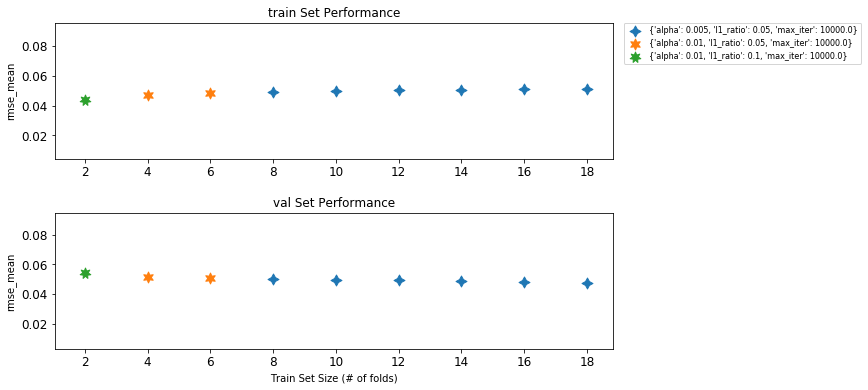

In [17]:
""" TODO
Plot the mean (summary) train and validation set performances for 
the best parameter set for each train size for the optimized 
metrics. Use plot_best_params_by_size()
"""
# TODO
crossval.plot_best_params_by_size()

In [ ]:
all

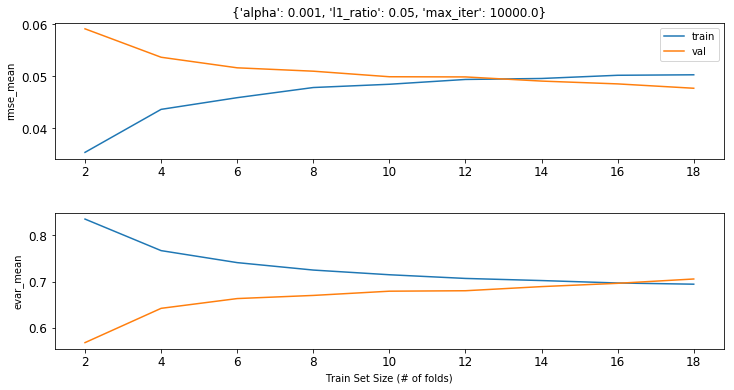

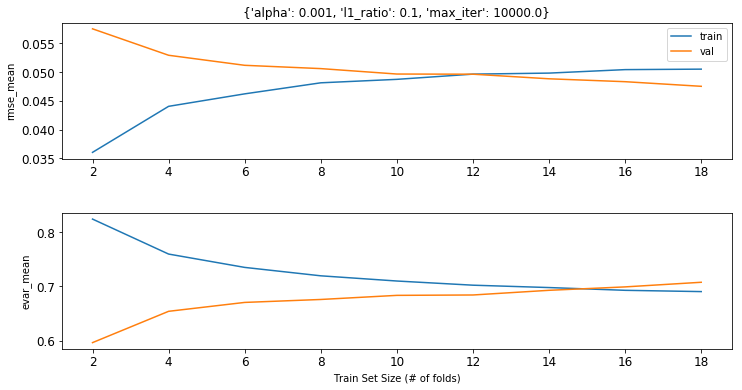

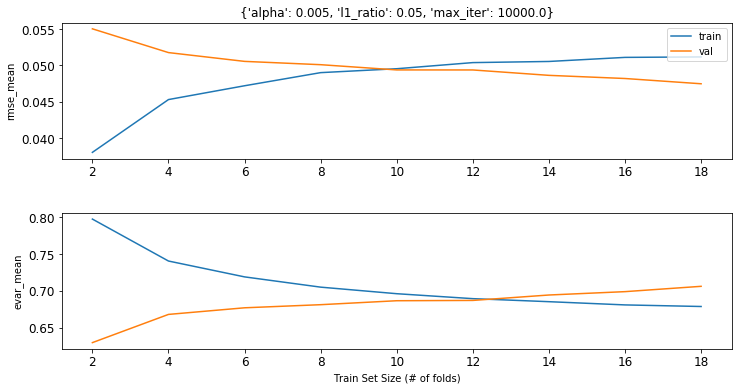

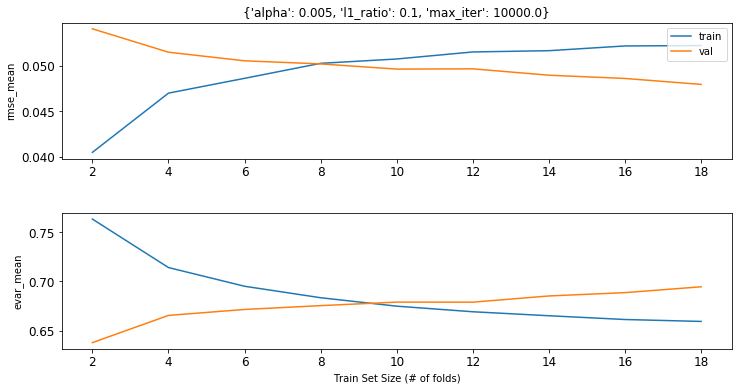

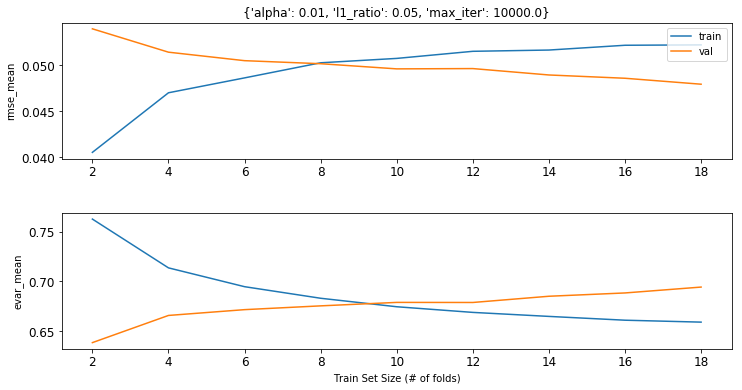

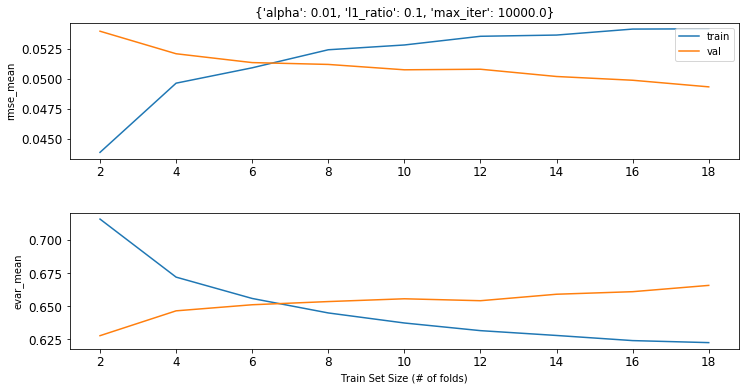

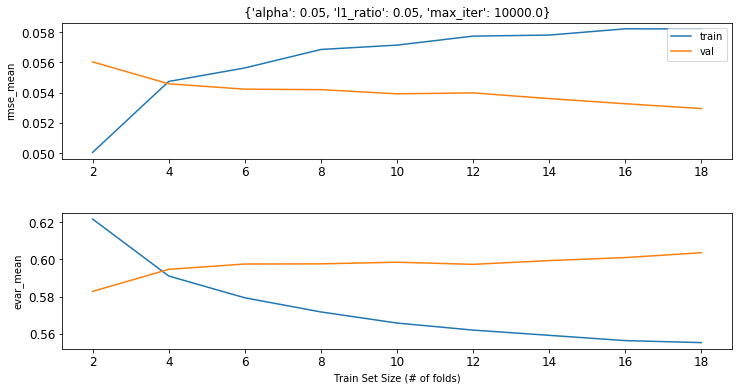

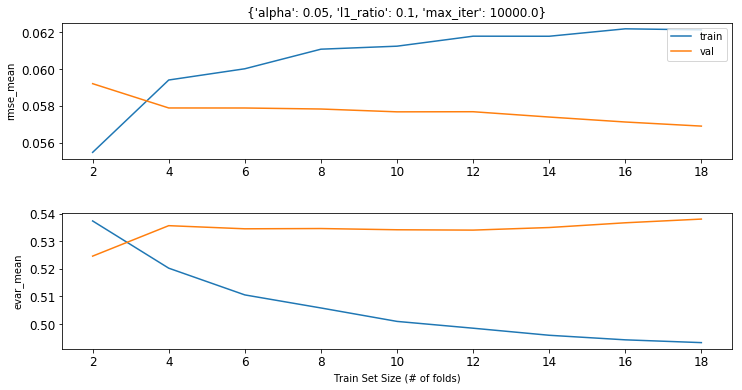

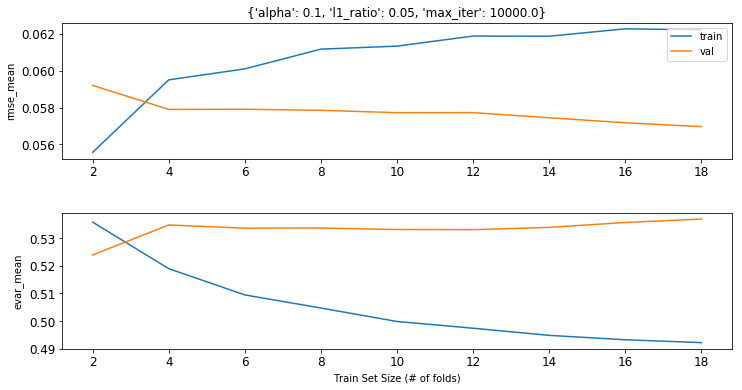

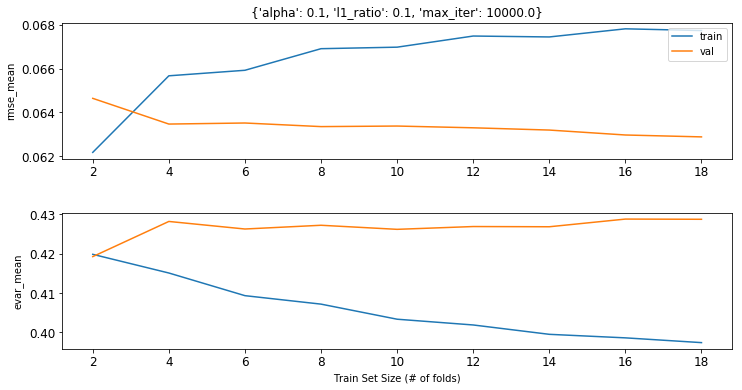

In [50]:
""" TODO
Plot the average results (summary) over train set size for all 
parameter sets for the metrics 'rmse_mean' and 'evar_mean'
for the train and val sets. Use plot_param_train_val(). 
view_test=False
"""
metrics = ['rmse_mean', 'evar_mean']

# TODO
for i in range(len(allparamsets)):
    crossval.plot_param_train_val(metrics, paramidx=i, view_test=False)

(<Figure size 720x432 with 2 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x2abb98e24430>,
       dtype=object))

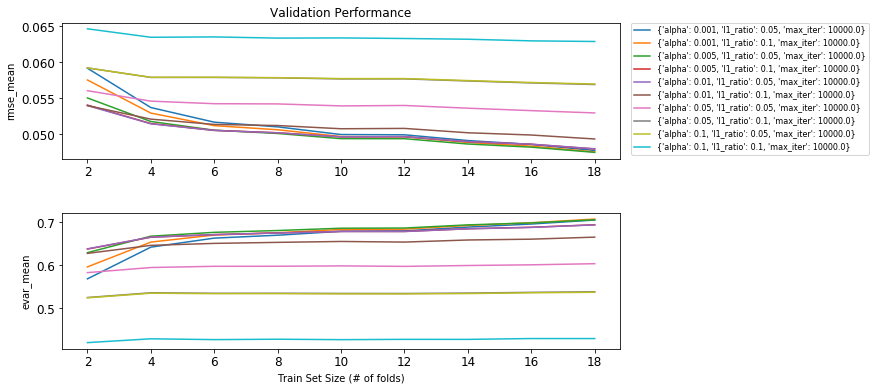

In [22]:
""" TODO
Plot the validation results for all parameters over all train 
sizes, for the specified metrics. Use plot_allparams_val()
"""
# TODO
crossval.plot_allparams_val(metrics)

(<Figure size 864x432 with 1 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x2abb88607520>],
       dtype=object))

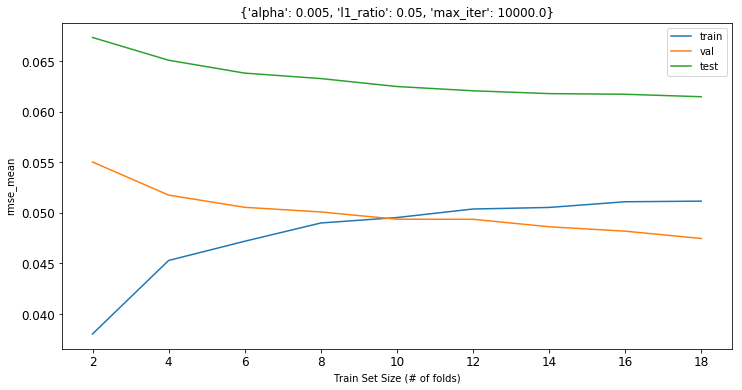

In [56]:
""" TODO
For the best parameter set for the train set size at index 5,
plot the TRAIN, VAL, and TEST set performances using 
plot_param_train_val() for just the optimized metric
"""
size_idx = 5
# TODO
best_param = best_param_inds[size_idx]
crossval.plot_param_train_val(['rmse_mean'], paramidx = best_param, view_test =True)

In [44]:
""" TODO
Use get_report_best_params_for_size() to display the report of  
the average val statistics for the best parameter set, for the 
train set size at index 5 (i.e. size_idx)
"""
report_best_params = crossval.get_report_best_params_for_size(size_idx)# TODO
report_best_params

,params,size,mse_mean,mse_std,rmse_mean,rmse_std,evar_mean,evar_std,score_mean,score_std
0,"{'alpha': 0.005, 'l1_ratio': 0.05, 'max_iter':...",2.0,0.003819043179307888,0.0015543968257203092,0.05502657932334771,0.01163533219812247,0.6294318358800848,0.060093679418763264,0.7673304695868742,0.05527524173921689
1,"{'alpha': 0.005, 'l1_ratio': 0.05, 'max_iter':...",4.0,0.0033597731253251677,0.0013182003854369444,0.05175409015365981,0.010769400283119877,0.6678371603010342,0.05593818322407418,0.7939920370167537,0.051310856799276314
2,"{'alpha': 0.005, 'l1_ratio': 0.05, 'max_iter':...",6.0,0.0031610543155015606,0.0011987467170312097,0.05054394353147333,0.009908498022872496,0.6768410807626971,0.036151306686257864,0.8061857250321282,0.03647475237100122
3,"{'alpha': 0.005, 'l1_ratio': 0.05, 'max_iter':...",8.0,0.003080832515885049,0.0010821119268900228,0.05008854982201633,0.009141598473819613,0.6810745072453914,0.03437584189803007,0.8099248805828045,0.029266165863175264
4,"{'alpha': 0.005, 'l1_ratio': 0.05, 'max_iter':...",10.0,0.002980548832974239,0.0010648927987964812,0.049367740139580056,0.009081021583593495,0.6864634943316148,0.03688444363937953,0.8163261331888183,0.028278040732562418
5,"{'alpha': 0.005, 'l1_ratio': 0.05, 'max_iter':...",12.0,0.0029786532968053515,0.001068840965471677,0.049362940495290414,0.009047985953177302,0.6868781574098263,0.03914914197863333,0.8162702421024107,0.02754716923195955
6,"{'alpha': 0.005, 'l1_ratio': 0.05, 'max_iter':...",14.0,0.0028915033396896307,0.001094645044377807,0.04862134302627277,0.009242855475579684,0.6942555532063517,0.03909043543969504,0.8221461625194829,0.02962633053220861
7,"{'alpha': 0.005, 'l1_ratio': 0.05, 'max_iter':...",16.0,0.0028369291243087076,0.0010673848669120283,0.04818664571437396,0.009051560707253601,0.6988322757800303,0.03791417267489048,0.8252737753738817,0.02907756406943868
8,"{'alpha': 0.005, 'l1_ratio': 0.05, 'max_iter':...",18.0,0.0027431573547802503,0.0010002181026165383,0.04746263500523837,0.008721223410145513,0.7060798287987706,0.03566893736484861,0.830813337888962,0.02635212426778605
